In [30]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import nltk
import string
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.downloader import download 

from nltk.sentiment import SentimentAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import state_union
from nltk.tokenize import PunktSentenceTokenizer
from nltk.corpus import subjectivity

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from apyori import apriori
import networkx as nx 

download('vader_lexicon')
download('stopwords')
download('wordnet')
download('punkt')
download('omw-1.4')




[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/chenqian/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chenqian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chenqian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/chenqian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/chenqian/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
df = pd.read_csv("R_cleaned_data.csv")

In [3]:
def target_encode(age,gender):
    if age<=40 and gender=='Male':
        return 'Young men'
    elif age>40 and gender=='Male':
        return 'Old men'
    elif age<=40 and gender=='Female':
        return 'Young women'
    else:
        return 'Old women'

In [4]:
df['Age_normalized'] = df['Age'].apply(lambda x: sum(map(int,(x.split('-'))))/2)
df['Age'] = df.apply(lambda x: target_encode(x.Age_normalized,x.Gender),axis=1)

In [5]:
list(df)[:-9]

['Age',
 'Gender',
 'AMITRIPTYLINE',
 'BUPROPION',
 'CITALOPRAM',
 'DESVENLAFAXINE',
 'DOXEPIN',
 'DULOXETINE',
 'ESCITALOPRAM',
 'FLUOXETINE',
 'MIRTAZAPINE',
 'NORTRIPTYLINE',
 'PAROXETINE',
 'ROPINIROLE',
 'SERTRALINE',
 'TRAZODONE',
 'VENLAFAXINE']

In [6]:
df = df[list(df)[:-9]]

In [7]:
for col in list(df)[2:]:
    df[col] = np.where(df[col].isnull(),float('nan'),col)

In [8]:
transactions = []
for i in tqdm(range(len(df))):
    transactions.append([str(df.values[i,j]) for j in range(0, df.shape[1])])

  0%|          | 0/16770 [00:00<?, ?it/s]

In [9]:
transactions_small = transactions[:]

In [11]:
# Training ARM - Apriori on the dataset
from apyori import apriori
rules = apriori(transactions_small, min_support = 0.02, min_confidence = 0.2, min_lift = 3, min_length = 2)

In [12]:
# Visualising the results
results = list(rules)

In [13]:
results

[RelationRecord(items=frozenset({'PAROXETINE', 'DULOXETINE'}), support=0.020691711389385806, ordered_statistics=[OrderedStatistic(items_base=frozenset({'DULOXETINE'}), items_add=frozenset({'PAROXETINE'}), confidence=0.26109857035364936, lift=3.297155892191792), OrderedStatistic(items_base=frozenset({'PAROXETINE'}), items_add=frozenset({'DULOXETINE'}), confidence=0.26129518072289154, lift=3.2971558921917916)]),
 RelationRecord(items=frozenset({'TRAZODONE', 'DULOXETINE'}), support=0.023076923076923078, ordered_statistics=[OrderedStatistic(items_base=frozenset({'DULOXETINE'}), items_add=frozenset({'TRAZODONE'}), confidence=0.29119638826185107, lift=3.240453504413565), OrderedStatistic(items_base=frozenset({'TRAZODONE'}), items_add=frozenset({'DULOXETINE'}), confidence=0.25680159256801594, lift=3.2404535044135647)]),
 RelationRecord(items=frozenset({'VENLAFAXINE', 'DULOXETINE'}), support=0.029278473464519977, ordered_statistics=[OrderedStatistic(items_base=frozenset({'DULOXETINE'}), items_

In [14]:
def inspect(results):
    lhs         = [tuple(result[2][0][0])[0] for result in results]
    rhs         = [tuple(result[2][0][1])[0] for result in results]
    supports    = [result[1] for result in results]
    confidences = [result[2][0][2] for result in results]
    lifts       = [result[2][0][3] for result in results]
    return list(zip(lhs, rhs, supports, confidences, lifts))
resultsinDataFrame = pd.DataFrame(inspect(results), columns = ['Left Hand Side', 'Right Hand Side', 'Support', 'Confidence', 'Lift'])

In [15]:
resultsinDataFrame

,Left Hand Side,Right Hand Side,Support,Confidence,Lift
0,DULOXETINE,PAROXETINE,0.020692,0.261099,3.297156
1,DULOXETINE,TRAZODONE,0.023077,0.291196,3.240454
2,DULOXETINE,VENLAFAXINE,0.029278,0.369451,3.712216
3,Male,Old men,0.180382,0.707437,3.921890
4,Male,Young men,0.074597,0.292563,3.921890
...,...,...,...,...,...
205,SERTRALINE,FLUOXETINE,0.021467,0.345489,3.041395
206,CITALOPRAM,FLUOXETINE,0.020632,0.585448,14.146930
207,DULOXETINE,CITALOPRAM,0.020572,0.259594,7.732480
208,CITALOPRAM,FLUOXETINE,0.023614,0.439024,10.732418


In [16]:
resultsinDataFrame.nlargest(n = 10, columns = 'Lift')

,Left Hand Side,Right Hand Side,Support,Confidence,Lift
164,CITALOPRAM,FLUOXETINE,0.022063,0.626058,14.622541
206,CITALOPRAM,FLUOXETINE,0.020632,0.585448,14.146930
71,CITALOPRAM,FLUOXETINE,0.023256,0.659898,12.913066
165,CITALOPRAM,FLUOXETINE,0.021825,0.619289,12.467566
75,CITALOPRAM,FLUOXETINE,0.024925,0.707276,12.202691
167,CITALOPRAM,FLUOXETINE,0.023494,0.666667,11.793249
72,CITALOPRAM,ESCITALOPRAM,0.024270,0.688663,11.136821
178,CITALOPRAM,FLUOXETINE,0.024508,0.455654,10.900598
208,CITALOPRAM,FLUOXETINE,0.023614,0.439024,10.732418
166,CITALOPRAM,SERTRALINE,0.022838,0.648054,10.728399


- 'BUPROPION' and 'ESCITALOPRAM' will go together to treat the patient

In [26]:
# INSERT CODE TO RE-FORMAT THE APRIORI OUTPUT INTO A PANDAS DATA-FRAME WITH COLUMNS "rhs","lhs","supp","conf","supp x conf","lift"
def reformat_results(results):
    keep=[]
    for i in range(0,len(results)):
        for j in range(0,len(list(results[i]))):
            if (j>1):
                for k in range(0,len(list(results[i][j]))):
                    if(len(results[i][j][k][0])!=0):
                        rhs = list(results[i][j][k][0])
                        lhs = list(results[i][j][k][1])
                        conf = float(results[i][j][k][2])
                        lift = float(results[i][j][k][3])
                        keep.append([rhs,lhs,supp,conf,supp*conf,lift])
            if(j==1):
                supp = results[i][j]
    return pd.DataFrame(keep,columns=["rhs","lhs","supp","conf","supp * conf","lift"])

In [21]:
def convert_to_network(df):
    print(df)

    #BUILD GRAPH
    G = nx.DiGraph()  # DIRECTED
    for row in df.iterrows():
        # for column in df.columns:
        lhs="_".join(row[1][0])
        rhs="_".join(row[1][1])
        conf=row[1][3]; #print(conf)
        if(lhs not in G.nodes): 
            G.add_node(lhs)
        if(rhs not in G.nodes): 
            G.add_node(rhs)

        edge=(lhs,rhs)
        if edge not in G.edges:
            G.add_edge(lhs, rhs, weight=conf)

    # print(G.nodes)
    # print(G.edges)
    return G


In [36]:
def plot_network(G):
    #SPECIFIY X-Y POSITIONS FOR PLOTTING
    pos=nx.random_layout(G)

    #GENERATE PLOT
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 15)

    #assign colors based on attributes
    weights_e 	= [G[u][v]['weight'] for u,v in G.edges()]

    #SAMPLE CMAP FOR COLORS 
    cmap=plt.cm.get_cmap('Blues')
    colors_e 	= [cmap(G[u][v]['weight']*10) for u,v in G.edges()]

    #PLOT
    nx.draw(
    G,
    edgecolors="black",
    edge_color=colors_e,
    node_size=1000,
    linewidths=1,
    font_size=5,
    font_color="white",
    font_weight="bold",
    width=weights_e,
    with_labels=True,
    pos=pos,
    ax=ax
    )
    ax.set(title='Dracula')
    plt.show()

# raise

                                                    rhs             lhs  \
0                                          [DULOXETINE]    [PAROXETINE]   
1                                          [PAROXETINE]    [DULOXETINE]   
2                                          [DULOXETINE]     [TRAZODONE]   
3                                           [TRAZODONE]    [DULOXETINE]   
4                                          [DULOXETINE]   [VENLAFAXINE]   
...                                                 ...             ...   
2166  [CITALOPRAM, ESCITALOPRAM, FLUOXETINE, SERTRAL...   [VENLAFAXINE]   
2167  [CITALOPRAM, ESCITALOPRAM, VENLAFAXINE, FLUOXE...    [SERTRALINE]   
2168  [CITALOPRAM, ESCITALOPRAM, VENLAFAXINE, SERTRA...    [FLUOXETINE]   
2169  [CITALOPRAM, VENLAFAXINE, FLUOXETINE, SERTRALI...  [ESCITALOPRAM]   
2170  [ESCITALOPRAM, VENLAFAXINE, FLUOXETINE, SERTRA...    [CITALOPRAM]   

          supp      conf  supp * conf      lift  
0     0.020692  0.261099     0.005403  3.297156  

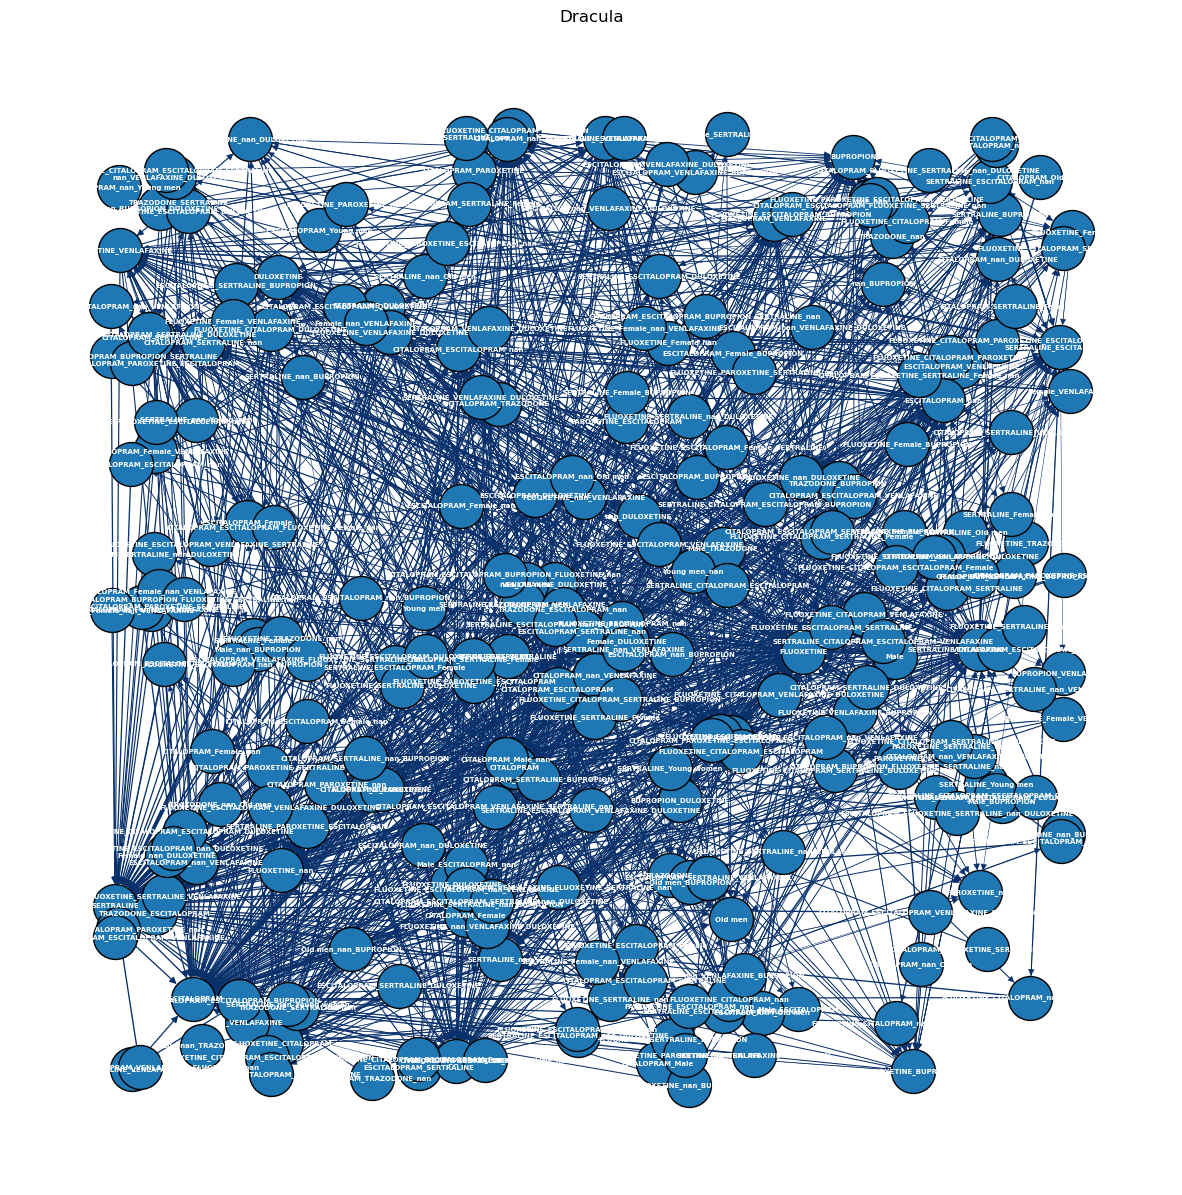

In [37]:
pd_results = reformat_results(results)
G=convert_to_network(pd_results)
plot_network(G)